# Using the virtual dot array

In this example we use the virtual dot array to show how to perofrm measurements and analysis using QTT. For a real device the measurements and analysis will go exactly the same (although you will have more noise and the scans will have more distortions).

In [1]:
%matplotlib inline
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import qcodes_loop
from qcodes_loop.data.data_set import DataSet
from qcodes_loop.plots.pyqtgraph import QtPlot
from qcodes_loop.plots.qcmatplotlib import MatPlot

import qtt
import qtt.measurements.videomode
import qtt.simulation.virtual_dot_array
from qtt import createParameterWidget
from qtt.algorithms.gatesweep import analyseGateSweep
from qtt.instrument_drivers.virtual_gates import create_virtual_matrix_dict, virtual_gates
from qtt.measurements.scans import scanjob_t

np.set_printoptions(precision=2, suppress=True)
datadir = tempfile.mkdtemp(prefix="qtt_example")
DataSet.default_io = qcodes_loop.data.io.DiskIO(datadir)

## Create a virtual model for testing

 The model resembles the spin-qubit dot setup. The hardware consists of a virtual
 keithley, IVVI racks and a virtual gates object

In [2]:
nr_dots = 3
station = qtt.simulation.virtual_dot_array.initialize(reinit=True, nr_dots=nr_dots, maxelectrons=2)
print(station.components.keys())

initialize: create virtual dot system
initialized virtual dot system (3 dots)
dict_keys(['gates', 'keithley1', 'keithley3', 'keithley4', 'ivvi1', 'ivvi2', 'vawg', 'sdigitizer', 'dotmodel'])


In [3]:
keithley1 = station.keithley1
keithley3 = station.keithley3

gates = station.gates

## Simple 1D scan loop

scan1D: 0/625: time 0.0
scan1D: 426/625: time 1.5
DataSet:
   location = '2023-05-02/15-46-08_qtt_scan1D'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | amplitude  | amplitude    | (625,)
   Setpoint | B3         | B3           | (625,)


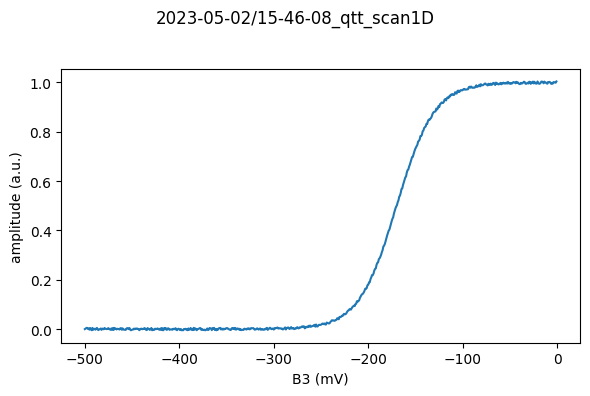

In [4]:
param_left = station.model.bottomgates[0]
param_right = station.model.bottomgates[-1]
scanjob = scanjob_t(
    {
        "sweepdata": dict({"param": param_right, "start": -500, "end": 0, "step": 0.8, "wait_time": 3e-3}),
        "minstrument": ["keithley3.amplitude"],
    }
)
data1d = qtt.measurements.scans.scan1D(station, scanjob, location=None, verbose=1)

print(data1d)

_ = MatPlot(data1d.default_parameter_array())

## Fit 1D pinch-off scan:

analyseGateSweep: pinch-off point -186.400, value 0.297


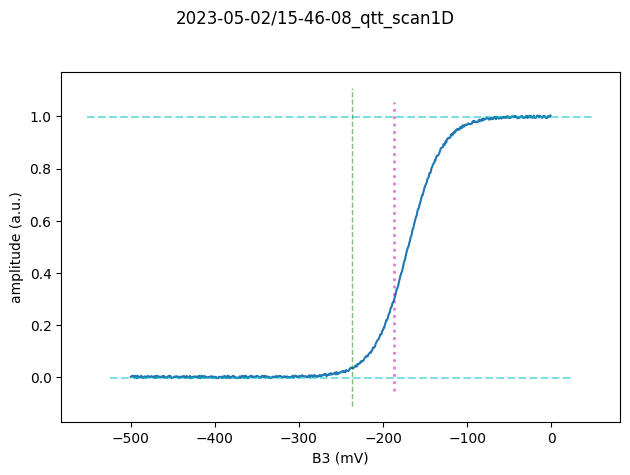

In [5]:
adata = analyseGateSweep(data1d, fig=100)

## Make a 2D scan

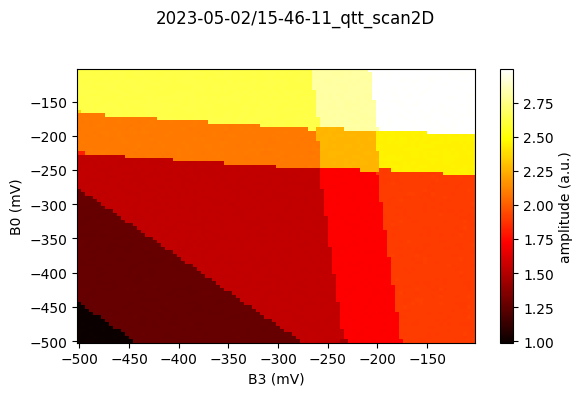

In [6]:
start = -500
scanjob = scanjob_t(
    {
        "sweepdata": dict({"param": param_right, "start": start, "end": start + 400, "step": 4.0, "wait_time": 0.0}),
        "minstrument": ["keithley1.amplitude"],
    }
)
scanjob["stepdata"] = dict({"param": param_left, "start": start, "end": start + 400, "step": 5.0})
data2d = qtt.measurements.scans.scan2D(station, scanjob)

_ = MatPlot(data2d.default_parameter_array())

In [7]:
gv = {
    "B0": -300.000,
    "B1": 0.145,
    "B2": -0.357,
    "B3": -300.000,
    "D0": 0.085,
    "O1": 0.222,
    "O2": -0.403,
    "O3": 0.117,
    "O4": -0.275,
    "O5": -0.163,
    "P1": 30.0,
    "P2": -40,
    "P3": -0.072,
    "SD1a": 0.254,
    "SD1b": -0.442,
    "SD1c": 0.252,
    "bias_1": 0.337,
    "bias_2": -0.401,
}
gates.resetgates(gv, gv)

resetgates: setting gates to default values
  setting gate B0 to -300.0 [mV]
  setting gate B1 to 0.1 [mV]
  setting gate B2 to -0.4 [mV]
  setting gate B3 to -300.0 [mV]
  setting gate D0 to 0.1 [mV]
  setting gate O1 to 0.2 [mV]
  setting gate O2 to -0.4 [mV]
  setting gate O3 to 0.1 [mV]
  setting gate O4 to -0.3 [mV]
  setting gate O5 to -0.2 [mV]
  setting gate P1 to 30.0 [mV]
  setting gate P2 to -40.0 [mV]
  setting gate P3 to -0.1 [mV]
  setting gate SD1a to 0.3 [mV]
  setting gate SD1b to -0.4 [mV]
  setting gate SD1c to 0.3 [mV]
  setting gate bias_1 to 0.3 [mV]
  setting gate bias_2 to -0.4 [mV]


## Make virtual gates

Instread of scanning physical gates, we can also scan linear combinations of gates. We use the `virtual_gates` object to define linear combinations and make scans.

In [8]:
gates.resetgates(gv, gv, 0)

c = np.array([[1, 0.56, 0.15], [0.62, 1, 0.593], [0.14, 0.62, 1.0]])
crosscap_map = create_virtual_matrix_dict(["vP1", "vP2", "vP3"], ["P1", "P2", "P3"], c=c)
virts = virtual_gates(qtt.measurements.scans.instrumentName("vgates"), gates, crosscap_map)
virts.print_matrix()

create_virtual_matrix_dict: adding vP1 
create_virtual_matrix_dict: adding vP2 
create_virtual_matrix_dict: adding vP3 
	P1	P2	P3
vP1	1	0.56	0.15
vP2	0.62	1	0.593
vP3	0.14	0.62	1


C:\dev\qtt-release-2\src\qtt\instrument_drivers\virtual_gates.py:-1: UserWarning: Call to deprecated function VirtualGates.


scan2D: 0/100: time 00:00:00 (~00:00:00 remaining): setting vP2 to -150.000


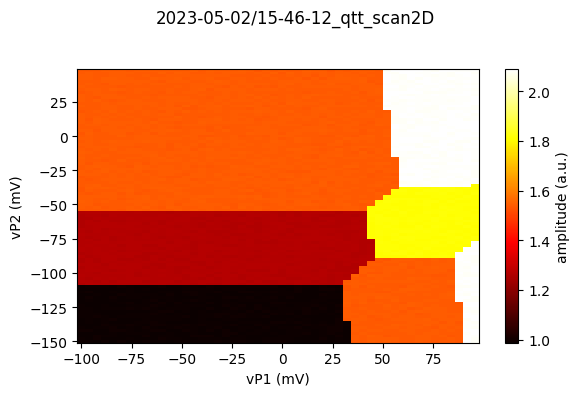

In [9]:
r = 100
scanjob = scanjob_t(
    {
        "sweepdata": dict({"param": virts.vP1, "start": -r, "end": r, "step": 4.0}),
        "minstrument": ["keithley1.amplitude"],
    }
)
scanjob["stepdata"] = dict({"param": virts.vP2, "start": -50 - r, "end": -50 + r, "step": 2.0})
data_virtual_gates = qtt.measurements.scans.scan2D(station, scanjob)

_ = MatPlot(data_virtual_gates.default_parameter_array())